In [2]:
# import data and modules
import numpy as np
import pandas as pd
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#from tpot.export_utils import set_param_recursive
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.linear_model import LassoLarsCV
#from sklearn.pipeline import make_pipeline, make_union
#from tpot.builtins import StackingEstimator
#from xgboost import XGBRegressor
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.linear_model import ElasticNetCV, RidgeCV
#from sklearn.preprocessing import MaxAbsScaler
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.preprocessing import FunctionTransformer
#from sklearn import preprocessing
from copy import copy
#from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
#from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
#from sklearn.preprocessing import StandardScaler

# import feature vectors
X = pd.read_csv('../dft_data/her/Xdata.csv').iloc[0:, 1:].values
#import target values (Gibbs free energy of hydrogen adsorption)
Y = pd.read_csv('../dft_data/her/ydata.csv').iloc[0:, 1].values


print(len(X))

1141


C:\Users\Public\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Public\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


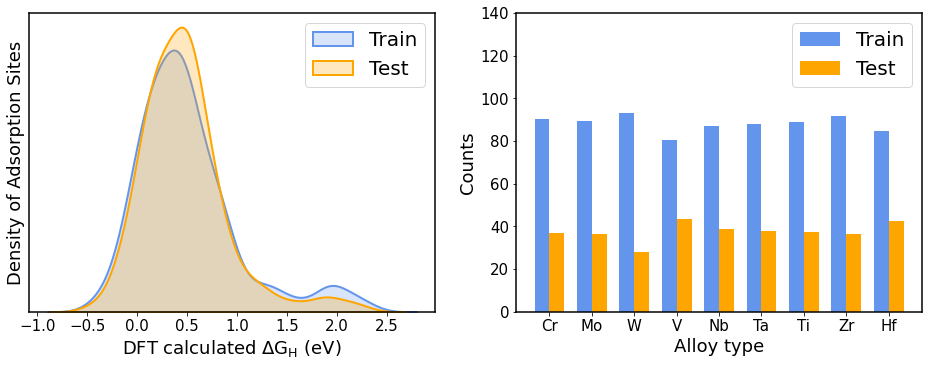

In [3]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

def class_element(data):
    atom = {24:0,42:0,74:0,23:0,41:0,73:0,22:0,40:0,72:0}
    for i in range(len(data)):
        s = set(data[i])
        for j in s:
            if j in atom:
                atom[j] += 1
    atom = atom.items()
    atom = sorted(atom)
    keys, values = zip(*atom)
    #print(keys)
    return keys, values

# data splitting
training_features, testing_features, training_target, testing_target =  \
        train_test_split(X, Y, random_state=42,train_size=0.7, test_size=0.3)

key_train,value_train = class_element(training_features)
w_train = np.array(value_train)/2

key_test,value_test = class_element(testing_features)
w_test = np.array(value_test)/2 

labels = ['Cr','Mo','W','V','Nb','Ta','Ti','Zr','Hf']
x = np.arange(len(labels))


fig = plt.figure(figsize=(16, 5.5))

ax = fig.add_subplot(1,2,1)

sns.distplot(training_target, hist=False, kde=True, 
             bins='auto', color = 'cornflowerblue', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,'shade': True,},
             label=r'Train')
sns.distplot(testing_target, hist=False, kde=True, 
             bins='auto', color = 'orange', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,'shade': True,},
             label=r'Test')

plt.xlabel(r'DFT calculated $\Delta$G$_\mathrm{H}$ (eV)',fontsize=18)
plt.ylabel(r'Density of Adsorption Sites',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([])
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')


ax = fig.add_subplot(1,2,2)
ax.set_xticks(x)
ax.set_xticklabels(labels)
width = 0.35
rects1 = plt.bar(x - width/2, w_train, width,label='Train',alpha=1,color='cornflowerblue')
rects2 = plt.bar(x + width/2, w_test, width, label='Test',alpha=1,color='orange')
plt.xlabel(r'Alloy type',fontsize=18)
plt.ylabel(r'Counts',fontsize=18)
plt.ylim((0, 140))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')


plt.show()

In [4]:
data_list = np.linspace(50,1140,20)

score_train_rmse = []
score_test_rmse = []
score_train_mae = []
score_test_mae = []
score_train_r2 = []
score_test_r2 = []

for i in data_list:
    i = int(i)
    x = X[0:i][:]
    y = Y[0:i]

    training_features, testing_features, training_target, testing_target = \
                train_test_split(x, y, random_state=42,train_size=0.7, test_size=0.3)

    exported_pipeline = GradientBoostingRegressor(
        alpha=0.9, learning_rate=0.05, loss="huber", max_depth=8, max_features=0.9, 
        min_samples_leaf=5, min_samples_split=17, n_estimators=100, subsample=0.8)
    
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', 42)
 
    exported_pipeline.fit(training_features, training_target)
    scores_mae = cross_val_score(exported_pipeline, training_features, training_target, scoring="neg_mean_absolute_error", cv=10)
    scores_rmse = cross_val_score(exported_pipeline, training_features, training_target, scoring="neg_mean_squared_error", cv=10)
    scores_r2 = cross_val_score(exported_pipeline, training_features, training_target, scoring="r2", cv=10)
    score_train_mae.append((-scores_mae.mean()))
    score_train_rmse.append((-scores_rmse.mean())**0.5)
    score_train_r2.append((scores_r2.mean()))
    
    scores1_mae = cross_val_score(exported_pipeline, testing_features, testing_target, scoring="neg_mean_absolute_error", cv=10)
    scores1_rmse = cross_val_score(exported_pipeline, testing_features, testing_target, scoring="neg_mean_squared_error", cv=10)
    scores1_r2 = cross_val_score(exported_pipeline, testing_features, testing_target, scoring="r2", cv=10)
    score_test_mae.append((-scores1_mae.mean()))
    score_test_rmse.append((-scores1_rmse.mean())**0.5)
    score_test_r2.append((scores1_r2.mean()))


C:\Users\Public\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Public\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Public\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Public\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Public\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Test RMSE:0.1573122103212111
Test MAE:0.10596725184545566
Test R2:0.8788065283245954
Train RMSE:0.13947244914845255
Train MAE:0.0872395771516098
Train R2:0.9166335306731463


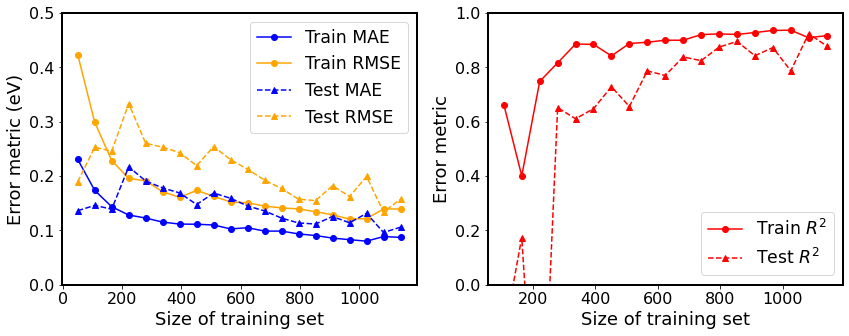

In [5]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(1,2,1)

plt.plot(data_list[0:], score_train_mae[0:], linestyle='-', linewidth=1.5, marker='o', label='Train MAE',color='blue')
plt.plot(data_list[0:], score_train_rmse[0:], linestyle='-', linewidth=1.5, marker='o', label='Train RMSE',color='orange')

plt.plot(data_list[0:], score_test_mae[0:], linestyle='--', linewidth=1.5, marker='^', label='Test MAE',color='blue')
plt.plot(data_list[0:], score_test_rmse[0:], linestyle='--', linewidth=1.5, marker='^', label='Test RMSE',color='orange')

plt.xlabel("Size of training set",fontsize=18)
plt.ylabel("Error metric (eV)",fontsize=18)
plt.ylim((0, 0.5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.setp(ax.spines.values(), linewidth=2)
plt.legend(bbox_to_anchor=(1,1),fontsize='xx-large',ncol=1)


print("Test RMSE:{}".format(score_test_rmse[-1]))
print("Test MAE:{}".format(score_test_mae[-1]))
print("Test R2:{}".format(score_test_r2[-1]))
print("Train RMSE:{}".format(score_train_rmse[-1]))
print("Train MAE:{}".format(score_train_mae[-1]))
print("Train R2:{}".format(score_train_r2[-1]))

ax = fig.add_subplot(1,2,2)

plt.plot(data_list[1:], score_train_r2[1:], linestyle='-', linewidth=1.5, marker='o', label='Train $R^2$',color='red')
plt.plot(data_list[1:], score_test_r2[1:], linestyle='--', linewidth=1.5, marker='^', label='Test $R^2$',color='red')
plt.xlabel("Size of training set",fontsize=18)
plt.ylabel("Error metric",fontsize=18)
plt.ylim((0, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.setp(ax.spines.values(), linewidth=2)
plt.legend(bbox_to_anchor=(1,0.3),fontsize='xx-large',ncol=1)
#plt.savefig('learning.png', bbox_inches='tight')
plt.show()

C:\Users\Public\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Public\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Public\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel 

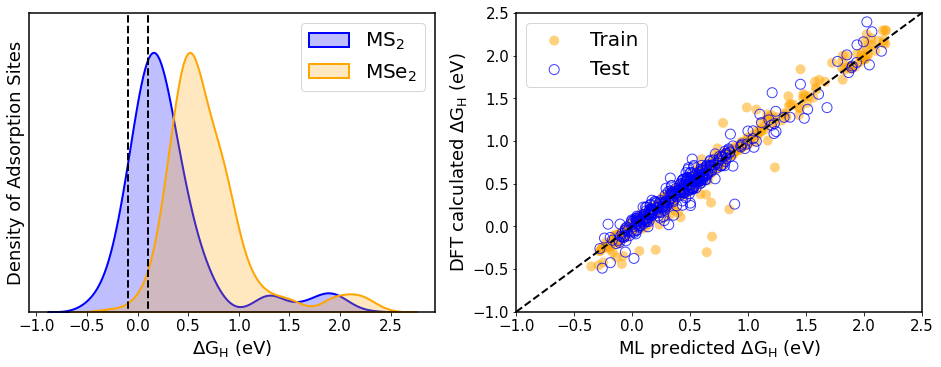

In [15]:
fig = plt.figure(figsize=(16, 5.5))
#ax = fig.add_subplot(111)
ax = fig.add_subplot(1,2,2)
plt.scatter(exported_pipeline.predict(training_features), training_target, marker='o', color='orange', label="Train", alpha = 0.5, s=100, edgecolors='none')
plt.scatter(exported_pipeline.predict(testing_features), testing_target, marker='o', color='none', label="Test",  alpha = 0.75, s=100, edgecolors='blue')#
#plt.plotmarkerfacecolor='none'
X_line = np.linspace(-1, 2.5, 100)
y_line = X_line
plt.plot(X_line, y_line, "k--",label='_Hidden label',linewidth=2)
plt.xlabel(r'ML predicted $\Delta$G$_\mathrm{H}$ (eV)',fontsize=18)
plt.ylabel(r'DFT calculated $\Delta$G$_\mathrm{H}$ (eV)',fontsize=18)
plt.xlim((-1, 2.5))
plt.ylim((-1, 2.5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')

ax = fig.add_subplot(1,2,1)

ys = Y[[list(range(0,290))+list(range(583,869))]]
yse = Y[[list(range(290,583))+list(range(869,1141))]]



# seaborn histogram
ax = sns.distplot(ys, hist=False, kde=True, 
             bins=int(3.5/0.1), color = 'blue', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,'shade': True,},
             label=r'MS$_2$')

sns.distplot(yse, hist=False, kde=True, 
             bins=int(3.5/0.1), color = 'orange', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2,'shade': True,},
             label=r'MSe$_2$')


# Add labels
#for _,s in ax.spines.items():
#    s.set_linewidth(1.5)
    #s.set_color('cyan')
#plt.title('Histogram of Arrival Delays')
plt.xlabel(r'$\Delta$G$_\mathrm{H}$ (eV)',fontsize=18)
plt.ylabel('Density of Adsorption Sites',fontsize=18)
plt.plot([-0.1,-0.1],[-0.1,1.6],'k--', linewidth=2)
plt.plot([0.1,0.1],[-0.1,1.6],'k--', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks([])
plt.ylim((0,1.6))
#plt.rcParams['axes.linewidth'] = 30
plt.setp(ax.spines.values(), linewidth=1.5)
plt.legend(loc="best",fontsize='20')
#plt.savefig('Density.png', bbox_inches='tight')
#plt.title("MSE = {:8.3f}".format(-scores.mean()))
#plt.savefig('fitting.png', bbox_inches='tight')
plt.show()



In [16]:
#save ml model
import joblib

joblib.dump(exported_pipeline, 'model_HER.pkl')

['model_HER.pkl']